In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Template Matching

In [61]:
def normalized_cross_correlation(image, template):
    h = np.zeros(image.shape)
    image_pad = cv2.copyMakeBorder(image, template.shape[0] // 2, template.shape[0] // 2, template.shape[1] // 2, template.shape[1] // 2, cv2.BORDER_REFLECT)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image_patch = image_pad[i: i + template.shape[0], j: j + template.shape[1]]
            h[i][j] = np.sum((template - np.mean(template))*(image_patch - np.mean(image_patch))) / (np.sum((template - np.mean(template))**2)*np.sum((image_patch - np.mean(image_patch))**2))**(1/2)
    return h
    
    
def ssd(image, template):
    h = np.zeros(image.shape)
    image_pad = cv2.copyMakeBorder(image, template.shape[0] // 2, template.shape[0] // 2, template.shape[1] // 2, template.shape[1] // 2, cv2.BORDER_REFLECT)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            h[i, j] = np.sum((template - image_pad[i: i + template.shape[0], j: j + template.shape[1]]) ** 2)
    return h

def draw_rectangle_at_matches(image, f, template_h, template_w, matches, flag):
    res = f.copy()
    coords = []
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            if flag:
                if f[i][j] <= matches:
                    coords.append((j, i))
            else: 
                if f[i][j] >= matches:
                    coords.append((j, i))
    print(coords)
    top_left = (min(coords, key=lambda x: x[0])[0] - template_w // 2, min(coords, key=lambda y: y[1])[1] - template_h//2)
    bottom_right = (max(coords, key=lambda x: x[0])[0] + template_w // 2, max(coords, key=lambda y: y[1])[1] + template_h//2)
    print(top_left, bottom_right)
    image = cv2.rectangle(image.copy(), top_left, bottom_right, (1, 1, 1), 1)
    return image
        

[(115, 113), (114, 114), (115, 114), (116, 114), (115, 115), (116, 115)]
(105, 107) (125, 121)
[(115, 113), (114, 114), (115, 114), (116, 114), (114, 115), (115, 115), (116, 115)]
(105, 107) (125, 121)


(Text(0.5, 1.0, 'NCC'), ([], []), ([], []))

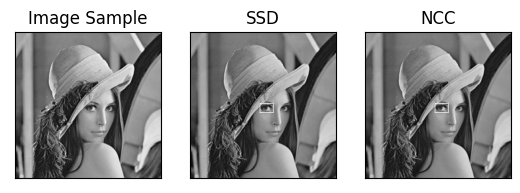

In [63]:
# read and convert to float and apply intensity transformation to image
image = cv2.imread("./data/lena.png", cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255
template = cv2.imread("./data/eye.png", cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255
result_ncc = normalized_cross_correlation(image, template)
result_ssd = ssd(image, template)
result_ssd /= np.max(result_ssd) 
# plt.imshow(result_ssd)
# plt.imshow(result_ncc)


plt.subplot(131)
plt.imshow(image ,cmap = 'gray')
plt.title('Image Sample'), plt.xticks([]), plt.yticks([])

drawed_ssd = draw_rectangle_at_matches(image, result_ssd, template.shape[0], template.shape[1], 0.1, True)
plt.subplot(132)
plt.imshow(drawed_ssd, cmap = 'gray')
plt.title('SSD'), plt.xticks([]), plt.yticks([])


drawed_ncc = draw_rectangle_at_matches(image, result_ncc, template.shape[0], template.shape[1], 0.7, False)
plt.subplot(133), plt.imshow(drawed_ncc, cmap = 'gray')
plt.title('NCC'), plt.xticks([]), plt.yticks([])

# Gaussian Pyramid

In [ ]:
def build_gaussian_pyramid_opencv(image, num_levels):
    result = []
    result.append(image)
    for _ in range(num_levels):
        image = cv2.pyrDown(image)
        result.append(image)
    return result


def build_gaussian_pyramid(image, num_levels):
    sigma = 1.0
    result = []
    result.append(image)
    for _ in range(num_levels):
        # Blur and then downsampling
        blurred_image = cv2.GaussianBlur(image, ksize=(5,5), sigmaX=sigma)
        image = blurred_image[0::2, 0::2]
        result.append(image)

    return result

In [ ]:
def template_matching_multiple_scales(pyramid_image, pyramid_template, show=False):
    threshold = 0.7
    window_size = 5
    
    # Reverse the pyramids, we start from the lowest resolution
    pyramid_image = pyramid_image[::-1]
    pyramid_template = pyramid_template[::-1]
    
    # Run NCC on the lowest resolution level, to find the most probable patches
    similarity_map = normalized_cross_correlation(pyramid_image[0], pyramid_template[0])
    
    if show:
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(pyramid_image[0], cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(pyramid_template[0], cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(similarity_map, cmap="gray")
    
    # Refine the initial prediction by running NCC on the patches found on previous level 
    for i in range(1, len(pyramid_image)):
        # Matches are the pixel where, in the previous level, the probability (of match) was higher
        matches = np.where(similarity_map >= threshold)
        matches = zip(matches[0], matches[1])
        
        similarity_map = np.zeros_like(pyramid_image[i])        
        
        for match in matches:       
            # Match the location in the higher scale image 
            match = [x*2 for x in match]  

            # We take a larger window wrt the patch, but we make sure it doesnt' go over the limits
            top_left = max(match[0]-window_size, 0), max(match[1]-window_size, 0)

            match[0] += pyramid_template[i].shape[0]
            match[1] += pyramid_template[i].shape[1]

            bottom_right = min(match[0]+window_size, pyramid_image[i].shape[0]), min(match[1]+window_size, pyramid_image[i].shape[1])

            patch = pyramid_image[i][
                top_left[0]:bottom_right[0], 
                top_left[1]:bottom_right[1]
            ]
            
            # Then we run the NCC only in the patch
            similarity_ncc = normalized_cross_correlation(patch, pyramid_template[i])
            # The dimension of similarity_ncc are lower than the patch
            similarity = np.zeros_like(patch)
            similarity[:similarity_ncc.shape[0], :similarity_ncc.shape[1]] = similarity_ncc

            previous_similarity_map = similarity_map[
                top_left[0]:bottom_right[0], 
                top_left[1]:bottom_right[1]
            ]
            # Find where the similarity is increased compared to previous matches
            mask = similarity > previous_similarity_map

            similarity_map[
                top_left[0]:bottom_right[0], 
                top_left[1]:bottom_right[1]
            ] = mask*similarity + (1-mask)*previous_similarity_map

        if show:
            plt.figure(figsize=(10,10))
            plt.subplot(1,3,1)
            plt.imshow(pyramid_image[i], cmap='gray')
            plt.subplot(1,3,2)
            plt.imshow(pyramid_template[i], cmap='gray')
            plt.subplot(1,3,3)
            plt.imshow(similarity_map, cmap="gray")
    
    return similarity_map

In [ ]:
cv_pyramid = build_gaussian_pyramid_opencv(image, 4)
cv_pyramid_template = build_gaussian_pyramid_opencv(template, 4)

my_pyramid = build_gaussian_pyramid(image, 4)
my_pyramid_template = build_gaussian_pyramid(template, 4)

In [42]:
image = cv2.imread("./data/traffic.jpg", cv2.IMREAD_GRAYSCALE) / 255
template = cv2.imread("./data/traffic-template.png", cv2.IMREAD_GRAYSCALE) / 255
start = time.time()
res_ncc = normalized_cross_correlation(image, template)
tem_h, tem_w = template.shape
result_without_opt = draw_rectangle_at_matches(image, res_ncc, tem_h, tem_w, 0.7, False)
end = time.time()
print(f"Time for matching without pyramid: {end-start}")

Time for matching without pyramid: 225.7632393836975


[(179, 300), (180, 300), (181, 300), (178, 301), (179, 301), (180, 301), (181, 301), (178, 302), (179, 302), (180, 302), (181, 302), (177, 303), (178, 303), (179, 303), (180, 303), (181, 303), (182, 303), (178, 304), (179, 304), (180, 304), (181, 304), (178, 305), (179, 305), (180, 305)]
(144, 270) (215, 335)


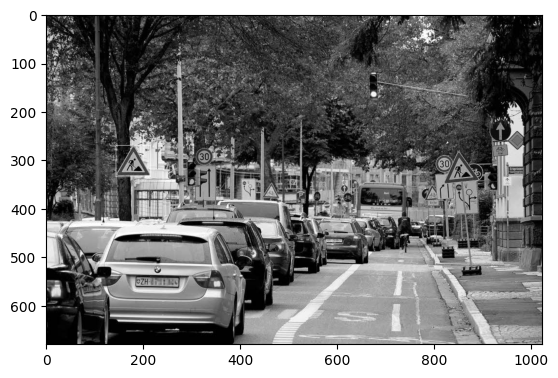

In [62]:
result_without_opt = draw_rectangle_at_matches(image, res_ncc, tem_h, tem_w, 0.7, False)
plt.imshow(result_without_opt, cmap="gray")

In [55]:
ncc_copy = res_ncc.copy()
ncc_copy[ncc_copy<0.7] = 0

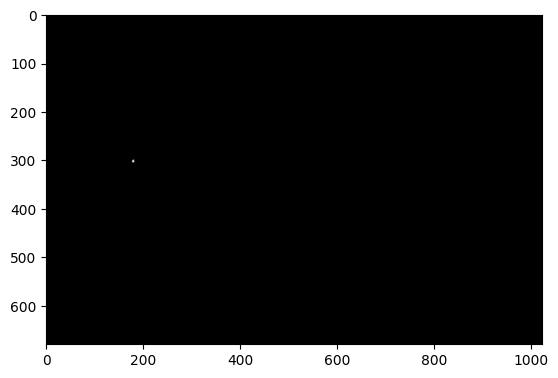

In [56]:
plt.imshow(ncc_copy, cmap="gray")

# Edges

In [8]:
def get_derivative_of_gaussian_kernel(size, sigma):
    ker_x = cv2.getGaussianKernel(size, sigma)
    ker_y = cv2.getGaussianKernel(size, sigma).transpose()

    ker_gauss = ker_x @ ker_y
    gradient = np.gradient(ker_gauss)

    return gradient


def non_max_suppression(gradient_magnitude, gradient_direction):
    mag_copy = gradient_magnitude.copy()
    gradient_direction = gradient_direction * 180 / np.pi + 90
    
    for i in range(1, gradient_magnitude.shape[0]-1):
        for j in range(1, gradient_magnitude.shape[1]-1):
            direct = gradient_direction[i][j]
            if 0 <= direct <=  22.5 or 157.5 <= direct <= 180:
                r = gradient_magnitude[i][j+1]
                p = gradient_magnitude[i][j-1]
            elif 22.5 <= direct <=  67.5:
                r = gradient_magnitude[i-1][j+1]
                p = gradient_magnitude[i+1][j-1]
            elif 67.5 <= direct <=  112.5:
                r = gradient_magnitude[i+1][j]
                p = gradient_magnitude[i-1][j]
            elif 112.5 <= direct <=  157.5:
                r = gradient_magnitude[i+1][j-1]
                p = gradient_magnitude[i-1][j+1]

            if gradient_magnitude[i][j] >= r and gradient_magnitude[i][j] >= p:
                mag_copy[i][j] = gradient_magnitude[i][j]
            else:
                mag_copy[i][j] = 0

    return mag_copy

Derivative of gaussian

C:\Users\vadim\AppData\Local\Temp\ipykernel_2168\294751927.py:12: RuntimeWarning: divide by zero encountered in divide
  direction = np.arctan(np.divide(edges_y, edges_x))  # TODO: compute edge direction


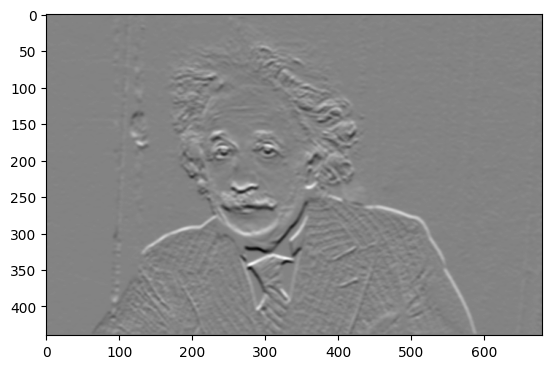

In [15]:
image = cv2.imread("./data/einstein.jpeg", cv2.IMREAD_GRAYSCALE).astype(np.float32)

kernel_x, kernel_y = get_derivative_of_gaussian_kernel(7, 2)

conv_res = cv2.filter2D(image, -1, kernel_y@kernel_x)

edges_x = cv2.filter2D(image, -1, kernel_x) 
edges_y = cv2.filter2D(image, -1, kernel_y) 

magnitude = np.sqrt(np.square(edges_x) + np.square(edges_y))
direction = np.arctan(np.divide(edges_y, edges_x)) 

suppressed_image = non_max_suppression(magnitude, direction)


Sobel

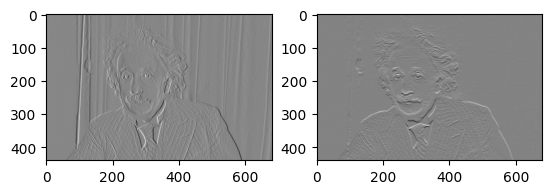

In [19]:
sobel_kernel_x, sobel_kernel_y = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]), np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

plt.subplot(121)
edge_sobel_x = cv2.filter2D(image, -1, sobel_kernel_x)
plt.imshow(edge_sobel_x, cmap="gray")

plt.subplot(122)
edge_sobel_y = cv2.filter2D(image, -1, sobel_kernel_y)  
plt.imshow(edge_sobel_y, cmap="gray")


# Distance Transform

(Text(0.5, 1.0, 'Distance transform'), ([], []), ([], []))

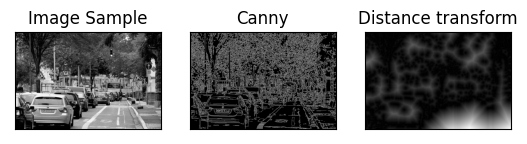

In [29]:
image = cv2.imread("./data/traffic.jpg", cv2.IMREAD_GRAYSCALE)

plt.subplot(131)
plt.imshow(image ,cmap = 'gray')
plt.title('Image Sample'), plt.xticks([]), plt.yticks([])

edges = cv2.Canny(image, 100, 200)
plt.subplot(132)
plt.imshow(edges ,cmap = 'gray')
plt.title('Canny'), plt.xticks([]), plt.yticks([])

dist_transform_cv = cv2.distanceTransform(image, cv2.DIST_L2, 3)
plt.subplot(133)
plt.imshow(dist_transform_cv ,cmap = 'gray')
plt.title('Distance transform'), plt.xticks([]), plt.yticks([])


(Text(0.5, 1.0, 'Distance transform filtered'), ([], []), ([], []))

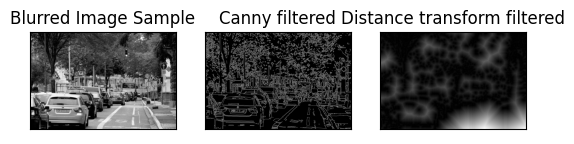

In [30]:
blured_image = cv2.GaussianBlur(image, (3, 3), 0)

plt.subplot(131)
plt.imshow(blured_image ,cmap = 'gray')
plt.title('Blurred Image Sample'), plt.xticks([]), plt.yticks([])

edges_filtered = cv2.Canny(blured_image, 100, 200)
plt.subplot(132)
plt.imshow(edges_filtered ,cmap = 'gray')
plt.title('Canny filtered'), plt.xticks([]), plt.yticks([])

dist_transform_cv_filtered = cv2.distanceTransform(blured_image, cv2.DIST_L2, 3)
plt.subplot(133)
plt.imshow(dist_transform_cv ,cmap = 'gray')
plt.title('Distance transform filtered'), plt.xticks([]), plt.yticks([])
